In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as sm

from imblearn.over_sampling import SMOTE

# from mpl_toolkits.basemap import BaseMap - Deprecated
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from scipy import stats

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from scipy.optimize import minimize, curve_fit

# from ydata_profiling import ProfileReport

%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', 200)

### Helper Functions

In [6]:
def pct_missing(input_df):
    print("Percentage Missing Values for each feature")
    return pd.DataFrame(input_df.isna().sum()/input_df.shape[0]*100, columns=['% Missing Values'])

In [7]:
def unique_values(input_df):
    print("Percentage Unique Values for each feature")
    return pd.DataFrame((input_df.nunique()/input_df.shape[0]*100), columns=['% Unique Values'])

In [8]:
def feature_entropy(input_df):
    output = pd.DataFrame(columns = ['column','Entropy'])
    tmp = pd.DataFrame()

    for c in input_df.columns:
        tmp['column'] = [c]
        tmp['Entropy'] = [round(stats.entropy(input_df[c].value_counts(), base=10),3)]
        output = output.append(tmp)

    return output.set_index('column')

In [9]:
def shuffle_split_data(X, y):
    """
    Manualy split dataset into train and test sets
    """
    np.random.seed(42)
    arr_rand = np.random.rand(X.shape[0])
    split = arr_rand < np.percentile(arr_rand, 70)

    X_train = X[split]
    y_train = y[split]
    X_test =  X[~split]
    y_test = y[~split]

    print(len(X_train), len(y_train), len(X_test), len(y_test))
    return X_train, y_train, X_test, y_test

In [10]:
def vif_cal(input_data, dependent_col):
    x_vars = input_data.drop([dependent_col], axis=1)
    xvar_names = x_vars.columns
    for i in range(0, xvar_names.shape[0]):
        y = x_vars[xvar_names[i]] 
        x = x_vars[xvar_names.drop(xvar_names[i])]
        rsq = sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif = round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)

In [12]:
def imputer(df):
    """
    Imputer function checks data type of each feature.
    If categorical, replaces missing value with modal value for feature.
    If numeric, replaces missing value it with median for feature.
    """
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True) 
    return df

In [13]:
def frequency_encoding(df, inp_column):
    fe = df.groupby(inp_column).size()/len(df)
    return df[inp_column].map(fe)

In [14]:
# Dataframe Summary:
def feature_summary(input_df):
    print("Dataframe Summary:")
    print("\n")
    print("Number of variables is %d"%input_df.shape[1])
    print("Number of observations is %d"%input_df.shape[0])
    print("Number of missing values is %d"%input_df.isnull().sum().sum())
    pct_missing = float(input_df.isnull().sum().sum())/float(input_df.shape[0]*input_df.shape[1])*100
    print("Percentage of missing values is %f"%round(pct_missing,3))
    print("There are %d categorical features."%(len(list(input_df.select_dtypes(include=['object']).columns))))
    print("There are %d numeric features."%(len(list(input_df.select_dtypes(include=['float64','int64']).columns))))
    # print("Column Types")
    print("\n")

In [15]:
# Summary statistics for categorical features
def categorical_profiling(input_df):
    """
    For each categorical varialble in a dataset, returns the value counts, missing values and modal value
    """
    ds_cat = input_df.select_dtypes(include = 'object').copy()
    ds_cat_stats = pd.DataFrame(columns = ['column', 'values', 'unique','modal_value',
                                           'values_count_incna', 'values_count_nona', 
                                           'num_miss', 'pct_miss'])
    tmp = pd.DataFrame()

    for c in ds_cat.columns:
        tmp['column'] = [c]
        tmp['values'] = [ds_cat[c].unique()]
        # Number of unique values
        tmp['unique'] = [ds_cat[c].nunique()]
        # Modal value
        tmp['modal_value'] = [ds_cat[c].mode()[0]]
        # Number of distinct categories incl na
        tmp['values_count_incna'] = len(list(ds_cat[c].unique()))
        # Number of distinct categories excl na
        tmp['values_count_exclna'] = int(ds_cat[c].nunique())
        # Number of missing values
        tmp['num_miss'] = ds_cat[c].isnull().sum()
        # Pct of missing values
        tmp['pct_miss'] = (ds_cat[c].isnull().sum()/ len(ds_cat)).round(3)*100
        ds_cat_stats = ds_cat_stats.append(tmp)

    return ds_cat_stats

## Data Ingestion
---

In [16]:
on_time_hix_path = "./BainAirlineTaskDatasets/Flight_on_time_HIX.csv"
flight_on_time_hix_raw_df = pd.read_csv(on_time_hix_path)
flight_on_time_hix_raw_df.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,1,103.0,62.0,15.0,118.0,127,219.0,52.0,7.0,212.0,LateAircraft
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,10,25.0,15.0,21.0,46.0,616,624.0,8.0,27.0,557.0,NaN
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,10,10.0,0.0,15.0,25.0,242,227.0,0.0,5.0,222.0,NaN
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,10,44.0,34.0,34.0,118.0,111,155.0,44.0,4.0,151.0,Weather
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,10,234.0,144.0,26.0,300.0,132,358.0,146.0,6.0,352.0,Carrier


In [17]:
flight_dict = pd.read_csv("./BainAirlineTaskDatasets/Data_Dictionary_Flight_on_time_HIX.txt", sep="delimiter", header=None, engine="python")
flight_dict = flight_dict.rename(columns={0:'initial'})
pd.DataFrame(flight_dict.initial.str.split(':',1).to_list(), columns = ['Field', 'Description'])

,Field,Description
0,Airline,Operating airline
1,Flight_Number,Flight number
2,Plane_ID,Plane identifier
3,FlightDate,Date of flight
4,Origin_Airport,Origin airport code
5,Destination_Airport,Destination airport code
6,Flight_Distance,Distance (miles) between origin and destination
7,Scheduled_Departure_Time,Scheduled departure time
8,(local time,hhmm)
9,Actual_Departure_Time,Actual departure time


In [18]:
feature_summary(flight_on_time_hix_raw_df)

Dataframe Summary:


Number of variables is 18
Number of observations is 65669
Number of missing values is 51588
Percentage of missing values is 4.364000
There are 6 categorical features.
There are 12 numeric features.




In [19]:
flight_on_time_hix_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65669 entries, 0 to 65668
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Airline                   65669 non-null  object 
 1   Flight_Number             65669 non-null  int64  
 2   Plane_ID                  65669 non-null  object 
 3   FlightDate                65669 non-null  object 
 4   Origin_Airport            65669 non-null  object 
 5   Destination_Airport       65669 non-null  object 
 6   Flight_Distance           65669 non-null  float64
 7   Scheduled_Departure_Time  65669 non-null  int64  
 8   Actual_Departure_Time     65669 non-null  float64
 9   Departure_Delay_Minutes   65669 non-null  float64
 10  Departure_Taxi            65669 non-null  float64
 11  Departure_WheelsOff       65669 non-null  float64
 12  Scheduled_Arrival_Time    65669 non-null  int64  
 13  Actual_Arrival_Time       65669 non-null  float64
 14  Arriva

In [20]:
# Summary statistics for numeric features
flight_on_time_hix_raw_df.describe()

,Flight_Number,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn
count,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,65669.000000,6.566900e+04,65669.000000,65669.000000
mean,4272.493170,692.798048,1305.444867,1314.054866,16.243052,21.114818,1344.385601,1471.367723,1461.438563,3.259466e+02,9.916460,1454.118153
std,1584.708511,502.328564,474.893882,484.243154,58.783502,11.900324,485.546072,504.200205,517.654681,1.929424e+04,7.789556,512.854299
min,1321.000000,67.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00,1.000000,1.000000
25%,2810.000000,299.000000,907.000000,917.000000,0.000000,14.000000,936.000000,1107.000000,1101.000000,0.000000e+00,5.000000,1056.000000
50%,4626.000000,599.000000,1304.000000,1313.000000,0.000000,18.000000,1329.000000,1455.000000,1454.000000,0.000000e+00,8.000000,1449.000000
75%,5420.000000,888.000000,1718.000000,1727.000000,7.000000,25.000000,1743.000000,1850.000000,1856.000000,1.000000e+01,12.000000,1848.000000
max,7613.000000,4243.000000,2359.000000,2400.000000,2710.000000,157.000000,2400.000000,2359.000000,2400.000000,2.510000e+06,160.000000,2400.000000


In [21]:
# Summary statistics for categorical features
categorical_profiling(flight_on_time_hix_raw_df)

,column,values,unique,modal_value,values_count_incna,values_count_nona,num_miss,pct_miss,values_count_exclna
0,Airline,"[TR, RO, XM, CA, NR, SN, ZH, YJ, TJ, GB, FH, UG, WC, TO, LV, VF]",16,NR,16,NaN,0,0.0,16.0
0,Plane_ID,"[GJLOAB, GDISCI, GHHWLL, GBGWFC, GBISBC, GBJODX, GBESAF, GCDTFM, GBDVFM, GDJRDD, GEKWHO, GGFVEG, GEENNK, GEJTNK, GFHSTX, GFDRTX, GEJNNK, GEETNK, GEJRNK, GBGOXF, GBDSDC, GBJSBG, GGDWHL, GBHWFM, GJG...",2708,GGJOWO,2708,NaN,0,0.0,2708.0
0,FlightDate,"[2019-12-01, 12/01/2019, 2019-12-02, 12/02/2019, 2019-12-03, 12/03/2019, 2019-12-04, 12/04/2019, 2019-12-05, 12/05/2019, 2019-12-06, 12/06/2019, 2019-12-07, 12/07/2019, 2019-12-08, 12/08/2019, 201...",62,2019-12-01,62,NaN,0,0.0,62.0
0,Origin_Airport,"[IYF, HEN, HIX, TLM, UKP, ERM, IYR, ERR, LWI, LVU, UFC, EJY, LPL, BRB, QEU, UFM, WWQ, FJH, FYE, VCN, YRL, YJX, HDU, VFO, XRO, XNL, KUO, FVG, LGC, FJJ, VCY, KJN, FCC, IZU, MMW, WRS, TMF, VDB, CCH, ...",170,HIX,170,NaN,0,0.0,170.0
0,Destination_Airport,"[HIX, IZN, IZU, LKF, MPM, EZN, FJS, LRN, UFM, XMP, VFO, FJH, VZX, VNU, TQI, KJN, KZW, LRP, VCY, ZJJ, VYM, TMJ, VCN, FTC, LPL, WWQ, FUN, ULZ, KFU, HIZ, TSY, VYI, KFW, FJJ, WJG, FTI, IYF, UEU, KUO, ...",169,HIX,169,NaN,0,0.0,169.0
0,Delay_Reason,"[LateAircraft, nan, Weather, Carrier, NAS, Security]",5,LateAircraft,6,NaN,51588,78.6,5.0


In [22]:
weather_path = "./BainAirlineTaskDatasets/weather.csv"
weather_raw_df = pd.read_csv(weather_path).iloc[: , 1:]
weather_raw_df.head()

,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation,time2
0,Highland,2019-11-30 00:00:00,Overcast,0.0000,0.00,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69,NaN,NaN,2019-11-30 00:00:00
1,Highland,2019-11-30 01:00:00,Possible Drizzle,0.0018,0.35,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09,rain,NaN,2019-11-30 01:00:00
2,Highland,2019-11-30 02:00:00,Possible Drizzle,0.0062,0.54,37.60,31.13,32.41,0.83,1017.91,8.04,8.57,112.053620,1.00,0,10.0,308.70,rain,NaN,2019-11-30 02:00:00
3,Highland,2019-11-30 03:00:00,Light Rain,0.0135,0.71,36.60,29.78,31.76,0.83,1016.64,8.90,9.84,103.033220,1.00,0,10.0,309.40,rain,NaN,2019-11-30 03:00:00
4,Highland,2019-11-30 04:00:00,Overcast,0.0007,0.06,36.65,31.12,32.41,0.85,1017.49,6.95,8.95,104.085209,1.00,0,10.0,311.82,rain,NaN,2019-11-30 04:00:00


In [23]:
weather_dict = pd.read_csv("./BainAirlineTaskDatasets/Data_Dictionary_weather.txt", sep="delimiter", header=None, engine="python")
weather_dict = weather_dict.rename(columns={0:'initial'})
pd.DataFrame(weather_dict.initial.str.split(':',1).to_list(), columns = ['Field', 'Description'])

,Field,Description
0,airport,Airport name
1,time,The datetime at which this data point begins.
2,summary,A human-readable text summary of this data point.
3,precipIntensity,The intensity (in inches of liquid water per hour) of precipitation occurring at the given time.
4,precipProbability,"The probability of precipitation occurring, between 0 and 1, inclusive."
5,temperature,The air temperature in degrees Fahrenheit.
6,apparentTemperature,The apparent (or “feels like”) temperature in degrees Fahrenheit.
7,dewPoint,The dew point in degrees Fahrenheit.
8,humidity,"The relative humidity, between 0 and 1, inclusive."
9,pressure,The sea-level air pressure in millibars.


In [24]:
feature_summary(weather_raw_df)

Dataframe Summary:


Number of variables is 20
Number of observations is 1536
Number of missing values is 2675
Percentage of missing values is 8.708000
There are 5 categorical features.
There are 15 numeric features.




In [25]:
weather_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   airport              1536 non-null   object 
 1   time                 1536 non-null   object 
 2   summary              1536 non-null   object 
 3   precipIntensity      1536 non-null   float64
 4   precipProbability    1536 non-null   float64
 5   temperature          1536 non-null   float64
 6   apparentTemperature  1536 non-null   float64
 7   dewPoint             1536 non-null   float64
 8   humidity             1536 non-null   float64
 9   pressure             1536 non-null   float64
 10  windSpeed            1536 non-null   float64
 11  windGust             1536 non-null   float64
 12  windBearing          1536 non-null   float64
 13  cloudCover           1536 non-null   float64
 14  uvIndex              1536 non-null   int64  
 15  visibility           1536 non-null   f

In [26]:
# Descriptive summary of numerical features
weather_raw_df.describe()

,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation
count,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,1536.000000,81.000000
mean,0.003304,0.117331,35.510918,29.115749,25.139629,0.675007,1016.511283,9.527930,11.326413,228.107328,0.598086,0.210938,9.083046,333.793210,0.044423
std,0.012533,0.303385,9.452021,12.087124,12.464821,0.155994,10.804320,4.448901,6.424565,82.520152,0.372036,0.420684,2.194884,30.406867,0.062452
min,0.000000,0.000000,11.530000,-2.150000,-13.040000,0.220000,985.900000,0.120000,0.260000,0.007128,0.000000,0.000000,0.498000,268.570000,0.001400
25%,0.000000,0.000000,29.850000,21.665000,17.982500,0.570000,1009.160000,6.460000,7.167500,190.030115,0.190000,0.000000,9.967750,310.827500,0.005600
50%,0.000000,0.000000,35.150000,28.445000,25.405000,0.700000,1018.075000,9.150000,10.250000,234.514672,0.690000,0.000000,10.000000,332.660000,0.016100
75%,0.000000,0.000000,40.490000,35.472500,32.330000,0.800000,1024.320000,12.100000,13.810000,291.075677,0.980000,0.000000,10.000000,353.605000,0.060000
max,0.129200,1.000000,62.120000,62.140000,55.840000,1.000000,1040.360000,24.770000,36.970000,359.077229,1.000000,2.000000,10.000000,423.560000,0.356200


In [27]:
# Summary of categorical data
categorical_profiling(weather_raw_df)

,column,values,unique,modal_value,values_count_incna,values_count_nona,num_miss,pct_miss,values_count_exclna
0,airport,"[Highland, Eureka]",2,Eureka,2,NaN,0,0.0,2.0
0,time,"[2019-11-30 00:00:00, 2019-11-30 01:00:00, 2019-11-30 02:00:00, 2019-11-30 03:00:00, 2019-11-30 04:00:00, 2019-11-30 05:00:00, 2019-11-30 06:00:00, 2019-11-30 07:00:00, 2019-11-30 08:00:00, 2019-1...",769,2019-11-30 00:00:00,769,NaN,0,0.0,769.0
0,summary,"[Overcast, Possible Drizzle, Light Rain, Rain, Drizzle, Possible Light Rain, Foggy, Possible Flurries, Light Snow, Mostly Cloudy, Partly Cloudy, Clear, Possible Light Snow, Flurries, Snow]",15,Clear,15,NaN,0,0.0,15.0
0,precipType,"[nan, rain, snow]",2,rain,3,NaN,1220,79.4,2.0
0,time2,"[2019-11-30 00:00:00, 2019-11-30 01:00:00, 2019-11-30 02:00:00, 2019-11-30 03:00:00, 2019-11-30 04:00:00, 2019-11-30 05:00:00, 2019-11-30 06:00:00, 2019-11-30 07:00:00, 2019-11-30 08:00:00, 2019-1...",769,2019-11-30 00:00:00,769,NaN,0,0.0,769.0


In [28]:
flight_on_time_hix_raw_df.head(50)

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,1,103.0,62.0,15.0,118.0,127,219.0,52.0,7.0,212.0,LateAircraft
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,10,25.0,15.0,21.0,46.0,616,624.0,8.0,27.0,557.0,NaN
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,10,10.0,0.0,15.0,25.0,242,227.0,0.0,5.0,222.0,NaN
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,10,44.0,34.0,34.0,118.0,111,155.0,44.0,4.0,151.0,Weather
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,10,234.0,144.0,26.0,300.0,132,358.0,146.0,6.0,352.0,Carrier
5,XM,5615,GBJODX,2019-12-01,HIX,MPM,475.0,10,144.0,94.0,11.0,155.0,249,418.0,89.0,4.0,414.0,Carrier
6,XM,5661,GBESAF,2019-12-01,HIX,EZN,552.0,10,14.0,4.0,24.0,38.0,206,219.0,13.0,11.0,208.0,NaN
7,CA,6526,GCDTFM,2019-12-01,TLM,HIX,977.0,10,22.0,12.0,18.0,40.0,259,252.0,0.0,10.0,242.0,NaN
8,CA,7201,GBDVFM,2019-12-01,UKP,HIX,763.0,10,2358.0,0.0,24.0,22.0,202,138.0,0.0,6.0,132.0,NaN
9,NR,3741,GDJRDD,2019-12-01,HIX,FJS,836.0,10,3.0,0.0,14.0,17.0,234,226.0,0.0,3.0,223.0,NaN


## Data Munging / Cleaning
---

In [29]:
flight_on_time_hix_raw_df2 = flight_on_time_hix_raw_df.copy()

In [30]:
# Let's add leading 00s to these four columns
flight_on_time_hix_raw_df2['Scheduled_Departure_Time'] = flight_on_time_hix_raw_df2['Scheduled_Departure_Time'].apply(str)
flight_on_time_hix_raw_df2['Actual_Departure_Time'] = flight_on_time_hix_raw_df2['Actual_Departure_Time'].astype(float).astype(int).astype(str)
flight_on_time_hix_raw_df2['Scheduled_Arrival_Time'] = flight_on_time_hix_raw_df2['Scheduled_Arrival_Time'].apply(str)
flight_on_time_hix_raw_df2['Actual_Arrival_Time'] = flight_on_time_hix_raw_df2['Actual_Arrival_Time'].astype(float).astype(int).astype(str)

flight_on_time_hix_raw_df2['Scheduled_Departure_Time'] = flight_on_time_hix_raw_df2['Scheduled_Departure_Time'].str.zfill(4)
flight_on_time_hix_raw_df2['Actual_Departure_Time'] = flight_on_time_hix_raw_df2['Actual_Departure_Time'].str.zfill(4)
flight_on_time_hix_raw_df2['Scheduled_Arrival_Time'] = flight_on_time_hix_raw_df2['Scheduled_Arrival_Time'].str.zfill(4)
flight_on_time_hix_raw_df2['Actual_Arrival_Time'] = flight_on_time_hix_raw_df2['Actual_Arrival_Time'].str.zfill(4)

In [31]:
flight_on_time_hix_raw_df2.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,0001,0103,62.0,15.0,118.0,0127,0219,52.0,7.0,212.0,LateAircraft
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,0010,0025,15.0,21.0,46.0,0616,0624,8.0,27.0,557.0,NaN
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,NaN
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,Weather
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,0010,0234,144.0,26.0,300.0,0132,0358,146.0,6.0,352.0,Carrier


In [32]:
# Combine strings of dates and times together
flight_on_time_hix_raw_df2['FlightSchedDepDateTime'] = flight_on_time_hix_raw_df2['FlightDate']+str(" ")+flight_on_time_hix_raw_df2['Scheduled_Departure_Time']
flight_on_time_hix_raw_df2['FlightActualDepDateTime'] = flight_on_time_hix_raw_df2['FlightDate']+str(" ")+flight_on_time_hix_raw_df2['Actual_Departure_Time']

flight_on_time_hix_raw_df2['FlightSchedArrDateTime'] = flight_on_time_hix_raw_df2['FlightDate']+str(" ")+flight_on_time_hix_raw_df2['Scheduled_Arrival_Time']
flight_on_time_hix_raw_df2['FlightActualArrDateTime'] = flight_on_time_hix_raw_df2['FlightDate']+str(" ")+flight_on_time_hix_raw_df2['Actual_Arrival_Time']

flight_on_time_hix_raw_df2.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,0001,0103,62.0,15.0,118.0,0127,0219,52.0,7.0,212.0,LateAircraft,2019-12-01 0001,2019-12-01 0103,2019-12-01 0127,2019-12-01 0219
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,0010,0025,15.0,21.0,46.0,0616,0624,8.0,27.0,557.0,NaN,2019-12-01 0010,2019-12-01 0025,2019-12-01 0616,2019-12-01 0624
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,NaN,2019-12-01 0010,2019-12-01 0010,2019-12-01 0242,2019-12-01 0227
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,Weather,2019-12-01 0010,2019-12-01 0044,2019-12-01 0111,2019-12-01 0155
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,0010,0234,144.0,26.0,300.0,0132,0358,146.0,6.0,352.0,Carrier,2019-12-01 0010,2019-12-01 0234,2019-12-01 0132,2019-12-01 0358


In [33]:
# Convert them to pandas DateTime format
flight_on_time_hix_raw_df2['FlightSchedDepDateTime'] = pd.to_datetime(flight_on_time_hix_raw_df2['FlightSchedDepDateTime'], errors='coerce')
flight_on_time_hix_raw_df2['FlightActualDepDateTime'] = pd.to_datetime(flight_on_time_hix_raw_df2['FlightActualDepDateTime'], errors='coerce')
flight_on_time_hix_raw_df2['FlightSchedArrDateTime'] = pd.to_datetime(flight_on_time_hix_raw_df2['FlightSchedArrDateTime'], errors='coerce')
flight_on_time_hix_raw_df2['FlightActualArrDateTime'] = pd.to_datetime(flight_on_time_hix_raw_df2['FlightActualArrDateTime'], errors='coerce')

flight_on_time_hix_raw_df2.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,0001,0103,62.0,15.0,118.0,0127,0219,52.0,7.0,212.0,LateAircraft,2019-12-01 00:01:00,2019-12-01 01:03:00,2019-12-01 01:27:00,2019-12-01 02:19:00
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,0010,0025,15.0,21.0,46.0,0616,0624,8.0,27.0,557.0,NaN,2019-12-01 00:10:00,2019-12-01 00:25:00,2019-12-01 06:16:00,2019-12-01 06:24:00
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,NaN,2019-12-01 00:10:00,2019-12-01 00:10:00,2019-12-01 02:42:00,2019-12-01 02:27:00
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,Weather,2019-12-01 00:10:00,2019-12-01 00:44:00,2019-12-01 01:11:00,2019-12-01 01:55:00
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,0010,0234,144.0,26.0,300.0,0132,0358,146.0,6.0,352.0,Carrier,2019-12-01 00:10:00,2019-12-01 02:34:00,2019-12-01 01:32:00,2019-12-01 03:58:00


In [34]:
# Finally get the scheduled vs actual departure/arrival hours of flights
flight_on_time_hix_raw_df2['Sched_Departure_Hour'] = flight_on_time_hix_raw_df2['FlightSchedDepDateTime'].dt.floor("H")
flight_on_time_hix_raw_df2['Actual_Departure_Hour'] = flight_on_time_hix_raw_df2['FlightActualDepDateTime'].dt.floor("H")

flight_on_time_hix_raw_df2['Sched_Arrival_Hour'] = flight_on_time_hix_raw_df2['FlightSchedArrDateTime'].dt.floor("H")
flight_on_time_hix_raw_df2['Actual_Arrival_Hour'] = flight_on_time_hix_raw_df2['FlightActualArrDateTime'].dt.floor("H")

flight_on_time_hix_raw_df2.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime,Sched_Departure_Hour,Actual_Departure_Hour,Sched_Arrival_Hour,Actual_Arrival_Hour
0,TR,4135,GJLOAB,2019-12-01,IYF,HIX,678.0,0001,0103,62.0,15.0,118.0,0127,0219,52.0,7.0,212.0,LateAircraft,2019-12-01 00:01:00,2019-12-01 01:03:00,2019-12-01 01:27:00,2019-12-01 02:19:00,2019-12-01,2019-12-01 01:00:00,2019-12-01 01:00:00,2019-12-01 02:00:00
1,TR,3776,GDISCI,2019-12-01,HEN,HIX,1700.0,0010,0025,15.0,21.0,46.0,0616,0624,8.0,27.0,557.0,NaN,2019-12-01 00:10:00,2019-12-01 00:25:00,2019-12-01 06:16:00,2019-12-01 06:24:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 06:00:00,2019-12-01 06:00:00
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,NaN,2019-12-01 00:10:00,2019-12-01 00:10:00,2019-12-01 02:42:00,2019-12-01 02:27:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 02:00:00,2019-12-01 02:00:00
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,Weather,2019-12-01 00:10:00,2019-12-01 00:44:00,2019-12-01 01:11:00,2019-12-01 01:55:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 01:00:00,2019-12-01 01:00:00
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,0010,0234,144.0,26.0,300.0,0132,0358,146.0,6.0,352.0,Carrier,2019-12-01 00:10:00,2019-12-01 02:34:00,2019-12-01 01:32:00,2019-12-01 03:58:00,2019-12-01,2019-12-01 02:00:00,2019-12-01 01:00:00,2019-12-01 03:00:00


In [35]:
# Convert weather data from strings to datetime
weather_raw_df2 = weather_raw_df.copy()

weather_raw_df2['time'] = pd.to_datetime(weather_raw_df2.time, errors='coerce')
weather_raw_df2['time2'] = pd.to_datetime(weather_raw_df2.time2, errors='coerce')
weather_raw_df2.head()

,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation,time2
0,Highland,2019-11-30 00:00:00,Overcast,0.0000,0.00,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69,NaN,NaN,2019-11-30 00:00:00
1,Highland,2019-11-30 01:00:00,Possible Drizzle,0.0018,0.35,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09,rain,NaN,2019-11-30 01:00:00
2,Highland,2019-11-30 02:00:00,Possible Drizzle,0.0062,0.54,37.60,31.13,32.41,0.83,1017.91,8.04,8.57,112.053620,1.00,0,10.0,308.70,rain,NaN,2019-11-30 02:00:00
3,Highland,2019-11-30 03:00:00,Light Rain,0.0135,0.71,36.60,29.78,31.76,0.83,1016.64,8.90,9.84,103.033220,1.00,0,10.0,309.40,rain,NaN,2019-11-30 03:00:00
4,Highland,2019-11-30 04:00:00,Overcast,0.0007,0.06,36.65,31.12,32.41,0.85,1017.49,6.95,8.95,104.085209,1.00,0,10.0,311.82,rain,NaN,2019-11-30 04:00:00


In [36]:
# Is there any difference between time and time2 columns?
weather_raw_df2['time_diff_mins'] = weather_raw_df2.time - weather_raw_df2.time2
weather_raw_df2['time_diff_mins'] = weather_raw_df2['time_diff_mins'].dt.seconds / 60
weather_raw_df2.head()

,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation,time2,time_diff_mins
0,Highland,2019-11-30 00:00:00,Overcast,0.0000,0.00,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69,NaN,NaN,2019-11-30 00:00:00,0.0
1,Highland,2019-11-30 01:00:00,Possible Drizzle,0.0018,0.35,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09,rain,NaN,2019-11-30 01:00:00,0.0
2,Highland,2019-11-30 02:00:00,Possible Drizzle,0.0062,0.54,37.60,31.13,32.41,0.83,1017.91,8.04,8.57,112.053620,1.00,0,10.0,308.70,rain,NaN,2019-11-30 02:00:00,0.0
3,Highland,2019-11-30 03:00:00,Light Rain,0.0135,0.71,36.60,29.78,31.76,0.83,1016.64,8.90,9.84,103.033220,1.00,0,10.0,309.40,rain,NaN,2019-11-30 03:00:00,0.0
4,Highland,2019-11-30 04:00:00,Overcast,0.0007,0.06,36.65,31.12,32.41,0.85,1017.49,6.95,8.95,104.085209,1.00,0,10.0,311.82,rain,NaN,2019-11-30 04:00:00,0.0


In [37]:
# Apparently not...
weather_raw_df2.time_diff_mins.value_counts()

0.0    1536
Name: time_diff_mins, dtype: int64

### Filter Down to HIX airport only

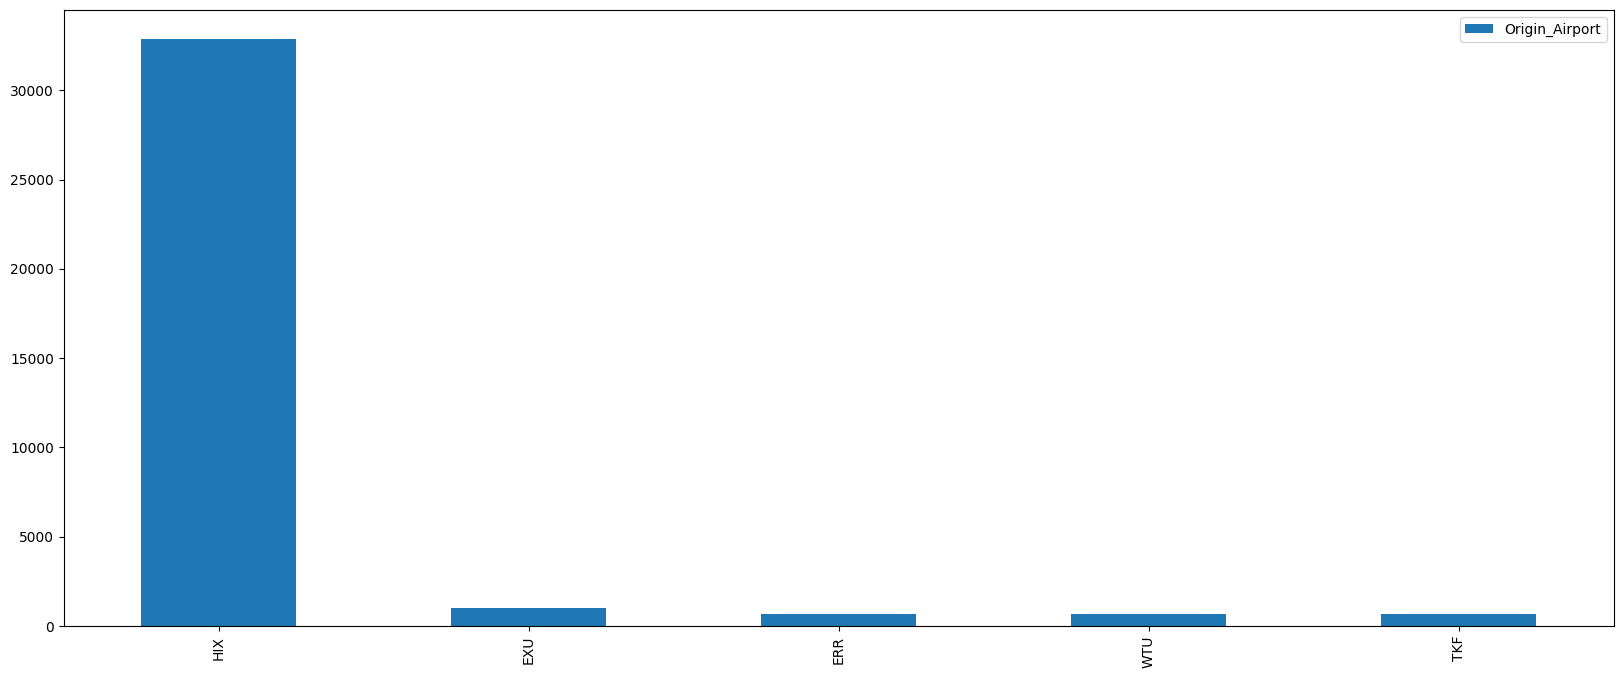

In [38]:
# What are the top 5 origin airports by count?
pd.DataFrame(flight_on_time_hix_raw_df2.Origin_Airport.value_counts()).head().plot(kind='bar', figsize=(20,8))
plt.show()

In [39]:
# Make a copy of the raw file
hix_departure_raw_df = flight_on_time_hix_raw_df2.copy()
# filter down to where origin airport is HIX only
hix_departure_raw_df = hix_departure_raw_df[hix_departure_raw_df.Origin_Airport == "HIX"] 
hix_departure_raw_df.head(10)

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime,Sched_Departure_Hour,Actual_Departure_Hour,Sched_Arrival_Hour,Actual_Arrival_Hour
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,NaN,2019-12-01 00:10:00,2019-12-01 00:10:00,2019-12-01 02:42:00,2019-12-01 02:27:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 02:00:00,2019-12-01 02:00:00
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,Weather,2019-12-01 00:10:00,2019-12-01 00:44:00,2019-12-01 01:11:00,2019-12-01 01:55:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 01:00:00,2019-12-01 01:00:00
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,0010,0234,144.0,26.0,300.0,0132,0358,146.0,6.0,352.0,Carrier,2019-12-01 00:10:00,2019-12-01 02:34:00,2019-12-01 01:32:00,2019-12-01 03:58:00,2019-12-01,2019-12-01 02:00:00,2019-12-01 01:00:00,2019-12-01 03:00:00
5,XM,5615,GBJODX,2019-12-01,HIX,MPM,475.0,0010,0144,94.0,11.0,155.0,0249,0418,89.0,4.0,414.0,Carrier,2019-12-01 00:10:00,2019-12-01 01:44:00,2019-12-01 02:49:00,2019-12-01 04:18:00,2019-12-01,2019-12-01 01:00:00,2019-12-01 02:00:00,2019-12-01 04:00:00
6,XM,5661,GBESAF,2019-12-01,HIX,EZN,552.0,0010,0014,4.0,24.0,38.0,0206,0219,13.0,11.0,208.0,NaN,2019-12-01 00:10:00,2019-12-01 00:14:00,2019-12-01 02:06:00,2019-12-01 02:19:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 02:00:00,2019-12-01 02:00:00
9,NR,3741,GDJRDD,2019-12-01,HIX,FJS,836.0,0010,0003,0.0,14.0,17.0,0234,0226,0.0,3.0,223.0,NaN,2019-12-01 00:10:00,2019-12-01 00:03:00,2019-12-01 02:34:00,2019-12-01 02:26:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 02:00:00,2019-12-01 02:00:00
10,NR,3535,GEKWHO,2019-12-01,HIX,LRN,1041.0,0010,0055,45.0,11.0,106.0,0310,0334,24.0,4.0,330.0,Carrier,2019-12-01 00:10:00,2019-12-01 00:55:00,2019-12-01 03:10:00,2019-12-01 03:34:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 03:00:00,2019-12-01 03:00:00
11,NR,2895,GGFVEG,2019-12-01,HIX,UFM,867.0,0010,0029,19.0,21.0,50.0,0325,0336,11.0,4.0,332.0,NaN,2019-12-01 00:10:00,2019-12-01 00:29:00,2019-12-01 03:25:00,2019-12-01 03:36:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 03:00:00,2019-12-01 03:00:00
12,SN,6159,GEENNK,2019-12-01,HIX,XMP,272.0,0010,0121,71.0,17.0,138.0,0126,0234,68.0,4.0,230.0,LateAircraft,2019-12-01 00:10:00,2019-12-01 01:21:00,2019-12-01 01:26:00,2019-12-01 02:34:00,2019-12-01,2019-12-01 01:00:00,2019-12-01 01:00:00,2019-12-01 02:00:00
13,SN,6143,GEJTNK,2019-12-01,HIX,VFO,315.0,0010,0236,146.0,14.0,250.0,0141,0347,126.0,5.0,342.0,LateAircraft,2019-12-01 00:10:00,2019-12-01 02:36:00,2019-12-01 01:41:00,2019-12-01 03:47:00,2019-12-01,2019-12-01 02:00:00,2019-12-01 01:00:00,2019-12-01 03:00:00


In [40]:
feature_summary(hix_departure_raw_df)

Dataframe Summary:


Number of variables is 26
Number of observations is 32863
Number of missing values is 25488
Percentage of missing values is 2.983000
There are 10 categorical features.
There are 8 numeric features.




In [41]:
hix_departure_raw_df.describe()

,Flight_Number,Flight_Distance,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn
count,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,3.286300e+04,32863.000000,32863.000000
mean,4282.909899,692.771902,15.907982,23.246174,1425.169522,3.425158e+02,6.822627,1552.112132
std,1584.647974,502.315076,53.117533,12.092565,477.320688,2.215887e+04,5.458769,514.818739
min,1322.000000,67.000000,0.000000,4.000000,1.000000,0.000000e+00,1.000000,1.000000
25%,2801.500000,299.000000,0.000000,16.000000,1025.000000,0.000000e+00,4.000000,1202.000000
50%,4623.000000,599.000000,0.000000,20.000000,1423.000000,0.000000e+00,5.000000,1547.000000
75%,5428.000000,888.000000,8.000000,27.000000,1843.000000,1.100000e+01,8.000000,2015.000000
max,7613.000000,4243.000000,1223.000000,156.000000,2359.000000,2.510000e+06,160.000000,2400.000000


In [42]:
hix_departure_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32863 entries, 2 to 65660
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Airline                   32863 non-null  object        
 1   Flight_Number             32863 non-null  int64         
 2   Plane_ID                  32863 non-null  object        
 3   FlightDate                32863 non-null  object        
 4   Origin_Airport            32863 non-null  object        
 5   Destination_Airport       32863 non-null  object        
 6   Flight_Distance           32863 non-null  float64       
 7   Scheduled_Departure_Time  32863 non-null  object        
 8   Actual_Departure_Time     32863 non-null  object        
 9   Departure_Delay_Minutes   32863 non-null  float64       
 10  Departure_Taxi            32863 non-null  float64       
 11  Departure_WheelsOff       32863 non-null  float64       
 12  Scheduled_Arrival_

In [43]:
categorical_profiling(hix_departure_raw_df)

,column,values,unique,modal_value,values_count_incna,values_count_nona,num_miss,pct_miss,values_count_exclna
0,Airline,"[RO, XM, NR, SN, ZH, CA, TR, UG, GB, WC, TJ, TO, YJ, FH, LV, VF]",16,NR,16,NaN,0,0.0,16.0
0,Plane_ID,"[GHHWLL, GBGWFC, GBISBC, GBJODX, GBESAF, GDJRDD, GEKWHO, GGFVEG, GEENNK, GEJTNK, GFHSTX, GFDRTX, GEJNNK, GEETNK, GEJRNK, GBGOXF, GBDSDC, GBJSBG, GGDWHL, GBHWFM, GJGUFK, GBFVFM, GHMUFY, GIHNHO, GIM...",2681,GFHSTX,2681,NaN,0,0.0,2681.0
0,FlightDate,"[2019-12-01, 12/01/2019, 2019-12-02, 12/02/2019, 2019-12-03, 12/03/2019, 2019-12-04, 12/04/2019, 2019-12-05, 12/05/2019, 2019-12-06, 12/06/2019, 2019-12-07, 12/07/2019, 2019-12-08, 12/08/2019, 201...",62,2019-12-01,62,NaN,0,0.0,62.0
0,Origin_Airport,[HIX],1,HIX,1,NaN,0,0.0,1.0
0,Destination_Airport,"[IZN, IZU, LKF, MPM, EZN, FJS, LRN, UFM, XMP, VFO, FJH, VZX, VNU, TQI, KJN, KZW, LRP, VCY, ZJJ, VYM, TMJ, VCN, FTC, LPL, WWQ, FUN, ULZ, KFU, HIZ, TSY, VYI, KFW, FJJ, WJG, FTI, IYF, UEU, KUO, UNC, ...",168,EXU,168,NaN,0,0.0,168.0
0,Scheduled_Departure_Time,"[0010, 0015, 0020, 0022, 0025, 0030, 0500, 0505, 0515, 0531, 0535, 0540, 0551, 0600, 0601, 0605, 0610, 0615, 0620, 0625, 0630, 0635, 0640, 0645, 0655, 0700, 0702, 0704, 0705, 0707, 0710, 0715, 071...",770,1000,770,NaN,0,0.0,770.0
0,Actual_Departure_Time,"[0010, 0044, 0234, 0144, 0014, 0003, 0055, 0029, 0121, 0236, 0139, 0227, 0009, 0023, 0100, 0006, 0013, 0011, 0138, 0017, 0030, 0131, 0120, 1215, 0128, 0022, 0016, 0306, 0112, 0032, 0117, 0059, 014...",1203,0958,1203,NaN,0,0.0,1203.0
0,Scheduled_Arrival_Time,"[0242, 0111, 0132, 0249, 0206, 0234, 0310, 0325, 0126, 0141, 0107, 0121, 0320, 0328, 0233, 0307, 0333, 0316, 0149, 0309, 0300, 0255, 0324, 0308, 0306, 0147, 0139, 0401, 0321, 0156, 0319, 0329, 074...",1030,2158,1030,NaN,0,0.0,1030.0
0,Actual_Arrival_Time,"[0227, 0155, 0358, 0418, 0219, 0226, 0334, 0336, 0234, 0347, 0223, 0325, 0119, 0211, 0108, 0408, 0341, 0228, 0309, 0335, 0259, 0433, 0147, 0301, 0350, 0356, 0246, 1503, 0427, 0253, 0322, 0235, 013...",1221,2153,1221,NaN,0,0.0,1221.0
0,Delay_Reason,"[nan, Weather, Carrier, LateAircraft, NAS, Security]",5,LateAircraft,6,NaN,25464,77.5,5.0


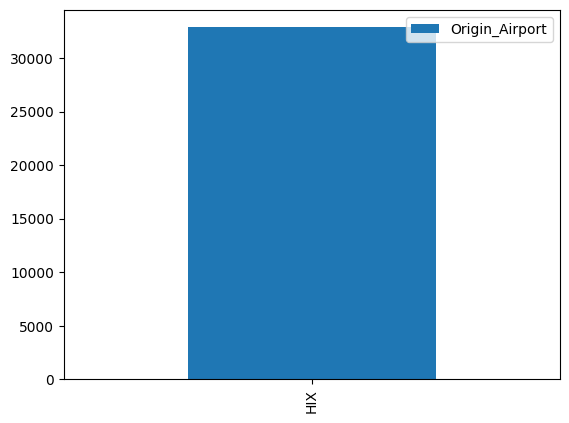

In [44]:
# Do a value_counts to confirm we only have HIX departures only
pd.DataFrame(hix_departure_raw_df.Origin_Airport.value_counts()).plot(kind='bar')
plt.show()

In [45]:
hix_departure_delay_df = hix_departure_raw_df.copy()
hix_departure_delay_df['flight_delayed'] = np.where(hix_departure_delay_df.Departure_Delay_Minutes > 15.0, 1, 0)
hix_departure_delay_df.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime,Sched_Departure_Hour,Actual_Departure_Hour,Sched_Arrival_Hour,Actual_Arrival_Hour,flight_delayed
2,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,NaN,2019-12-01 00:10:00,2019-12-01 00:10:00,2019-12-01 02:42:00,2019-12-01 02:27:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 02:00:00,2019-12-01 02:00:00,0
3,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,Weather,2019-12-01 00:10:00,2019-12-01 00:44:00,2019-12-01 01:11:00,2019-12-01 01:55:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 01:00:00,2019-12-01 01:00:00,1
4,XM,5612,GBISBC,2019-12-01,HIX,LKF,258.0,0010,0234,144.0,26.0,300.0,0132,0358,146.0,6.0,352.0,Carrier,2019-12-01 00:10:00,2019-12-01 02:34:00,2019-12-01 01:32:00,2019-12-01 03:58:00,2019-12-01,2019-12-01 02:00:00,2019-12-01 01:00:00,2019-12-01 03:00:00,1
5,XM,5615,GBJODX,2019-12-01,HIX,MPM,475.0,0010,0144,94.0,11.0,155.0,0249,0418,89.0,4.0,414.0,Carrier,2019-12-01 00:10:00,2019-12-01 01:44:00,2019-12-01 02:49:00,2019-12-01 04:18:00,2019-12-01,2019-12-01 01:00:00,2019-12-01 02:00:00,2019-12-01 04:00:00,1
6,XM,5661,GBESAF,2019-12-01,HIX,EZN,552.0,0010,0014,4.0,24.0,38.0,0206,0219,13.0,11.0,208.0,NaN,2019-12-01 00:10:00,2019-12-01 00:14:00,2019-12-01 02:06:00,2019-12-01 02:19:00,2019-12-01,2019-12-01 00:00:00,2019-12-01 02:00:00,2019-12-01 02:00:00,0


#### From profiling the raw weather data we note there is data for `two` airports

In [46]:
categorical_profiling(weather_raw_df2).head(1)

,column,values,unique,modal_value,values_count_incna,values_count_nona,num_miss,pct_miss,values_count_exclna
0,airport,"[Highland, Eureka]",2,Eureka,2,NaN,0,0.0,2.0


In [47]:
hix_weather_df = weather_raw_df2.copy()
hix_weather_df = hix_weather_df[hix_weather_df.airport == 'Highland']
hix_weather_df.head()

,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation,time2,time_diff_mins
0,Highland,2019-11-30 00:00:00,Overcast,0.0000,0.00,37.30,32.11,32.47,0.82,1019.58,6.70,8.06,141.090120,1.00,0,10.0,309.69,NaN,NaN,2019-11-30 00:00:00,0.0
1,Highland,2019-11-30 01:00:00,Possible Drizzle,0.0018,0.35,37.74,33.16,32.10,0.80,1018.31,5.77,7.58,110.003815,0.95,0,10.0,309.09,rain,NaN,2019-11-30 01:00:00,0.0
2,Highland,2019-11-30 02:00:00,Possible Drizzle,0.0062,0.54,37.60,31.13,32.41,0.83,1017.91,8.04,8.57,112.053620,1.00,0,10.0,308.70,rain,NaN,2019-11-30 02:00:00,0.0
3,Highland,2019-11-30 03:00:00,Light Rain,0.0135,0.71,36.60,29.78,31.76,0.83,1016.64,8.90,9.84,103.033220,1.00,0,10.0,309.40,rain,NaN,2019-11-30 03:00:00,0.0
4,Highland,2019-11-30 04:00:00,Overcast,0.0007,0.06,36.65,31.12,32.41,0.85,1017.49,6.95,8.95,104.085209,1.00,0,10.0,311.82,rain,NaN,2019-11-30 04:00:00,0.0


In [48]:
# Let's remove unwanted columns
hix_weather_df.drop(['time2', 'time_diff_mins'], axis=1, inplace=True)

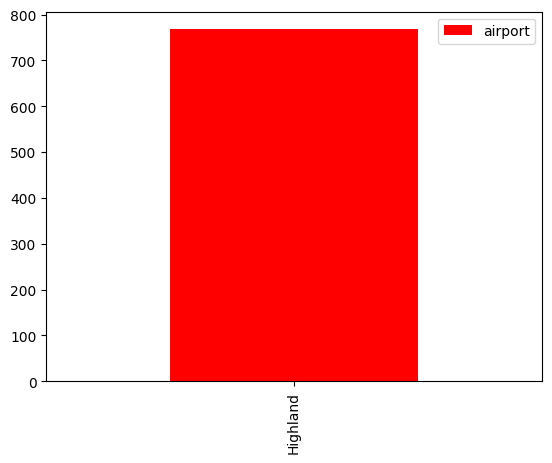

In [49]:
# Confirm that weather data only has Highland airport only HIX
pd.DataFrame(hix_weather_df.airport.value_counts()).plot(kind='bar', colormap='autumn')
plt.show()

In [50]:
# Merge Highlands weather and HIX departure data together
hix_merged_dep_wthr_df = hix_departure_delay_df.merge(hix_weather_df, left_on='Actual_Departure_Hour', right_on='time')
hix_merged_dep_wthr_df.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,Delay_Reason,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime,Sched_Departure_Hour,Actual_Departure_Hour,Sched_Arrival_Hour,Actual_Arrival_Hour,flight_delayed,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipType,precipAccumulation
0,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,NaN,2019-12-01 00:10:00,2019-12-01 00:10:00,2019-12-01 02:42:00,2019-12-01 02:27:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,0,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28,rain,NaN
1,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,Weather,2019-12-01 00:10:00,2019-12-01 00:44:00,2019-12-01 01:11:00,2019-12-01 01:55:00,2019-12-01,2019-12-01,2019-12-01 01:00:00,2019-12-01 01:00:00,1,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28,rain,NaN
2,XM,5661,GBESAF,2019-12-01,HIX,EZN,552.0,0010,0014,4.0,24.0,38.0,0206,0219,13.0,11.0,208.0,NaN,2019-12-01 00:10:00,2019-12-01 00:14:00,2019-12-01 02:06:00,2019-12-01 02:19:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,0,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28,rain,NaN
3,NR,3741,GDJRDD,2019-12-01,HIX,FJS,836.0,0010,0003,0.0,14.0,17.0,0234,0226,0.0,3.0,223.0,NaN,2019-12-01 00:10:00,2019-12-01 00:03:00,2019-12-01 02:34:00,2019-12-01 02:26:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,0,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28,rain,NaN
4,NR,3535,GEKWHO,2019-12-01,HIX,LRN,1041.0,0010,0055,45.0,11.0,106.0,0310,0334,24.0,4.0,330.0,Carrier,2019-12-01 00:10:00,2019-12-01 00:55:00,2019-12-01 03:10:00,2019-12-01 03:34:00,2019-12-01,2019-12-01,2019-12-01 03:00:00,2019-12-01 03:00:00,1,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28,rain,NaN


In [51]:
feature_summary(hix_merged_dep_wthr_df)

Dataframe Summary:


Number of variables is 46
Number of observations is 32863
Number of missing values is 86902
Percentage of missing values is 5.749000
There are 13 categorical features.
There are 24 numeric features.




In [52]:
hix_merged_dep_wthr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32863 entries, 0 to 32862
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Airline                   32863 non-null  object        
 1   Flight_Number             32863 non-null  int64         
 2   Plane_ID                  32863 non-null  object        
 3   FlightDate                32863 non-null  object        
 4   Origin_Airport            32863 non-null  object        
 5   Destination_Airport       32863 non-null  object        
 6   Flight_Distance           32863 non-null  float64       
 7   Scheduled_Departure_Time  32863 non-null  object        
 8   Actual_Departure_Time     32863 non-null  object        
 9   Departure_Delay_Minutes   32863 non-null  float64       
 10  Departure_Taxi            32863 non-null  float64       
 11  Departure_WheelsOff       32863 non-null  float64       
 12  Scheduled_Arrival_

In [53]:
categorical_profiling(hix_merged_dep_wthr_df)

,column,values,unique,modal_value,values_count_incna,values_count_nona,num_miss,pct_miss,values_count_exclna
0,Airline,"[RO, XM, NR, SN, CA, ZH, TR, TO, FH, WC, LV, UG, GB, TJ, YJ, VF]",16,NR,16,NaN,0,0.0,16.0
0,Plane_ID,"[GHHWLL, GBGWFC, GBESAF, GDJRDD, GEKWHO, GGFVEG, GEJNNK, GEETNK, GEJRNK, GBDSDC, GBJSBG, GGDWHL, GBHWFM, GJGUFK, GHMUFY, GIHNHO, GDLRBB, GFHQTX, GEFRNK, GEKOMK, GEJNHO, GIHOHO, GDLRBY, GHJPCG, GHK...",2681,GFHSTX,2681,NaN,0,0.0,2681.0
0,FlightDate,"[2019-12-01, 12/01/2019, 2019-12-02, 12/02/2019, 2019-12-03, 12/03/2019, 2019-12-04, 12/04/2019, 2019-12-05, 12/05/2019, 2019-12-06, 12/06/2019, 2019-12-07, 12/07/2019, 2019-12-08, 12/08/2019, 201...",62,2019-12-01,62,NaN,0,0.0,62.0
0,Origin_Airport,[HIX],1,HIX,1,NaN,0,0.0,1.0
0,Destination_Airport,"[IZN, IZU, EZN, FJS, LRN, UFM, VNU, TQI, KJN, LRP, VCY, ZJJ, VYM, TMJ, FTC, LPL, ULZ, TSY, VYI, KFW, FJJ, WJG, FTI, KUO, UUF, LWI, IYF, MPM, VDB, WRS, VRY, LUZ, BRX, LKF, VFO, VZX, XMP, FJH, KZW, ...",168,EXU,168,NaN,0,0.0,168.0
0,Scheduled_Departure_Time,"[0010, 0015, 0020, 0022, 0030, 2015, 2035, 2110, 2145, 2200, 2220, 2230, 2240, 2300, 2305, 2320, 0025, 1935, 2205, 1000, 1005, 1125, 1140, 1153, 1155, 1200, 1201, 1205, 1206, 1208, 1209, 1210, 121...",770,1000,770,NaN,0,0.0,770.0
0,Actual_Departure_Time,"[0010, 0044, 0014, 0003, 0055, 0029, 0009, 0023, 0006, 0013, 0011, 0017, 0030, 0022, 0016, 0032, 0059, 0001, 0002, 0036, 0025, 0024, 0045, 0019, 0020, 0234, 0236, 0227, 0206, 0144, 0121, 0139, 010...",1203,0958,1203,NaN,0,0.0,1203.0
0,Scheduled_Arrival_Time,"[0242, 0111, 0206, 0234, 0310, 0325, 0121, 0132, 0328, 0233, 0307, 0333, 0149, 0309, 0255, 0308, 0306, 0147, 0139, 0401, 0324, 0329, 2306, 2329, 2349, 2312, 0021, 0030, 0133, 0103, 0142, 0146, 014...",1030,2158,1030,NaN,0,0.0,1030.0
0,Actual_Arrival_Time,"[0227, 0155, 0219, 0226, 0334, 0336, 0119, 0211, 0108, 0341, 0228, 0309, 0335, 0259, 0147, 0301, 0246, 0253, 0322, 0235, 0130, 0131, 0410, 0327, 0349, 0316, 0222, 0151, 0240, 0323, 0304, 0256, 025...",1221,2153,1221,NaN,0,0.0,1221.0
0,Delay_Reason,"[nan, Weather, Carrier, NAS, LateAircraft, Security]",5,LateAircraft,6,NaN,25464,77.5,5.0


## Exploratory Data Analysis
---

In [54]:
pct_missing(hix_merged_dep_wthr_df)

Percentage Missing Values for each feature


,% Missing Values
Airline,0.000000
Flight_Number,0.000000
Plane_ID,0.000000
FlightDate,0.000000
Origin_Airport,0.000000
Destination_Airport,0.000000
Flight_Distance,0.000000
Scheduled_Departure_Time,0.000000
Actual_Departure_Time,0.000000
Departure_Delay_Minutes,0.000000


In [55]:
unique_values(hix_merged_dep_wthr_df)

Percentage Unique Values for each feature


,% Unique Values
Airline,0.048687
Flight_Number,6.861820
Plane_ID,8.158111
FlightDate,0.188662
Origin_Airport,0.003043
Destination_Airport,0.511213
Flight_Distance,0.477741
Scheduled_Departure_Time,2.343061
Actual_Departure_Time,3.660652
Departure_Delay_Minutes,1.220217


In [56]:
feature_entropy(hix_merged_dep_wthr_df)

,Entropy
column,
Airline,0.979
Flight_Number,3.206
Plane_ID,3.187
FlightDate,1.548
Origin_Airport,0.000
Destination_Airport,2.078
Flight_Distance,2.053
Scheduled_Departure_Time,2.516
Actual_Departure_Time,2.975


In [57]:
# Let us remove features which have 75%+ missing values
missing_features = ['Delay_Reason','precipType','precipAccumulation']
hix_merged_dep_wthr_df2 = hix_merged_dep_wthr_df.copy()
hix_merged_dep_wthr_df2.drop(missing_features, axis=1, inplace=True)
hix_merged_dep_wthr_df2.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime,Sched_Departure_Hour,Actual_Departure_Hour,Sched_Arrival_Hour,Actual_Arrival_Hour,flight_delayed,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone
0,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,2019-12-01 00:10:00,2019-12-01 00:10:00,2019-12-01 02:42:00,2019-12-01 02:27:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,0,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
1,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,2019-12-01 00:10:00,2019-12-01 00:44:00,2019-12-01 01:11:00,2019-12-01 01:55:00,2019-12-01,2019-12-01,2019-12-01 01:00:00,2019-12-01 01:00:00,1,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
2,XM,5661,GBESAF,2019-12-01,HIX,EZN,552.0,0010,0014,4.0,24.0,38.0,0206,0219,13.0,11.0,208.0,2019-12-01 00:10:00,2019-12-01 00:14:00,2019-12-01 02:06:00,2019-12-01 02:19:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,0,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
3,NR,3741,GDJRDD,2019-12-01,HIX,FJS,836.0,0010,0003,0.0,14.0,17.0,0234,0226,0.0,3.0,223.0,2019-12-01 00:10:00,2019-12-01 00:03:00,2019-12-01 02:34:00,2019-12-01 02:26:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,0,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
4,NR,3535,GEKWHO,2019-12-01,HIX,LRN,1041.0,0010,0055,45.0,11.0,106.0,0310,0334,24.0,4.0,330.0,2019-12-01 00:10:00,2019-12-01 00:55:00,2019-12-01 03:10:00,2019-12-01 03:34:00,2019-12-01,2019-12-01,2019-12-01 03:00:00,2019-12-01 03:00:00,1,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28


#### Outlier Analysis and Removal

In [58]:
# Let's create the correlation matarix but skip adding Departure_Delay_Minutes since this is used to calculate whether a flight is delayed or not.
corrmat = hix_merged_dep_wthr_df2.drop('Departure_Delay_Minutes', axis=1).corr()
series_corr = corrmat['flight_delayed'].sort_values(ascending=False).to_frame()
series_corr.style.background_gradient(cmap=sns.light_palette("seagreen", as_cmap=True))

,flight_delayed
flight_delayed,1.000000
Departure_WheelsOff,0.124272
ozone,0.109330
Departure_Taxi,0.093139
windSpeed,0.090143
cloudCover,0.076919
windGust,0.073922
precipProbability,0.069252
windBearing,0.068004
Flight_Number,0.046723


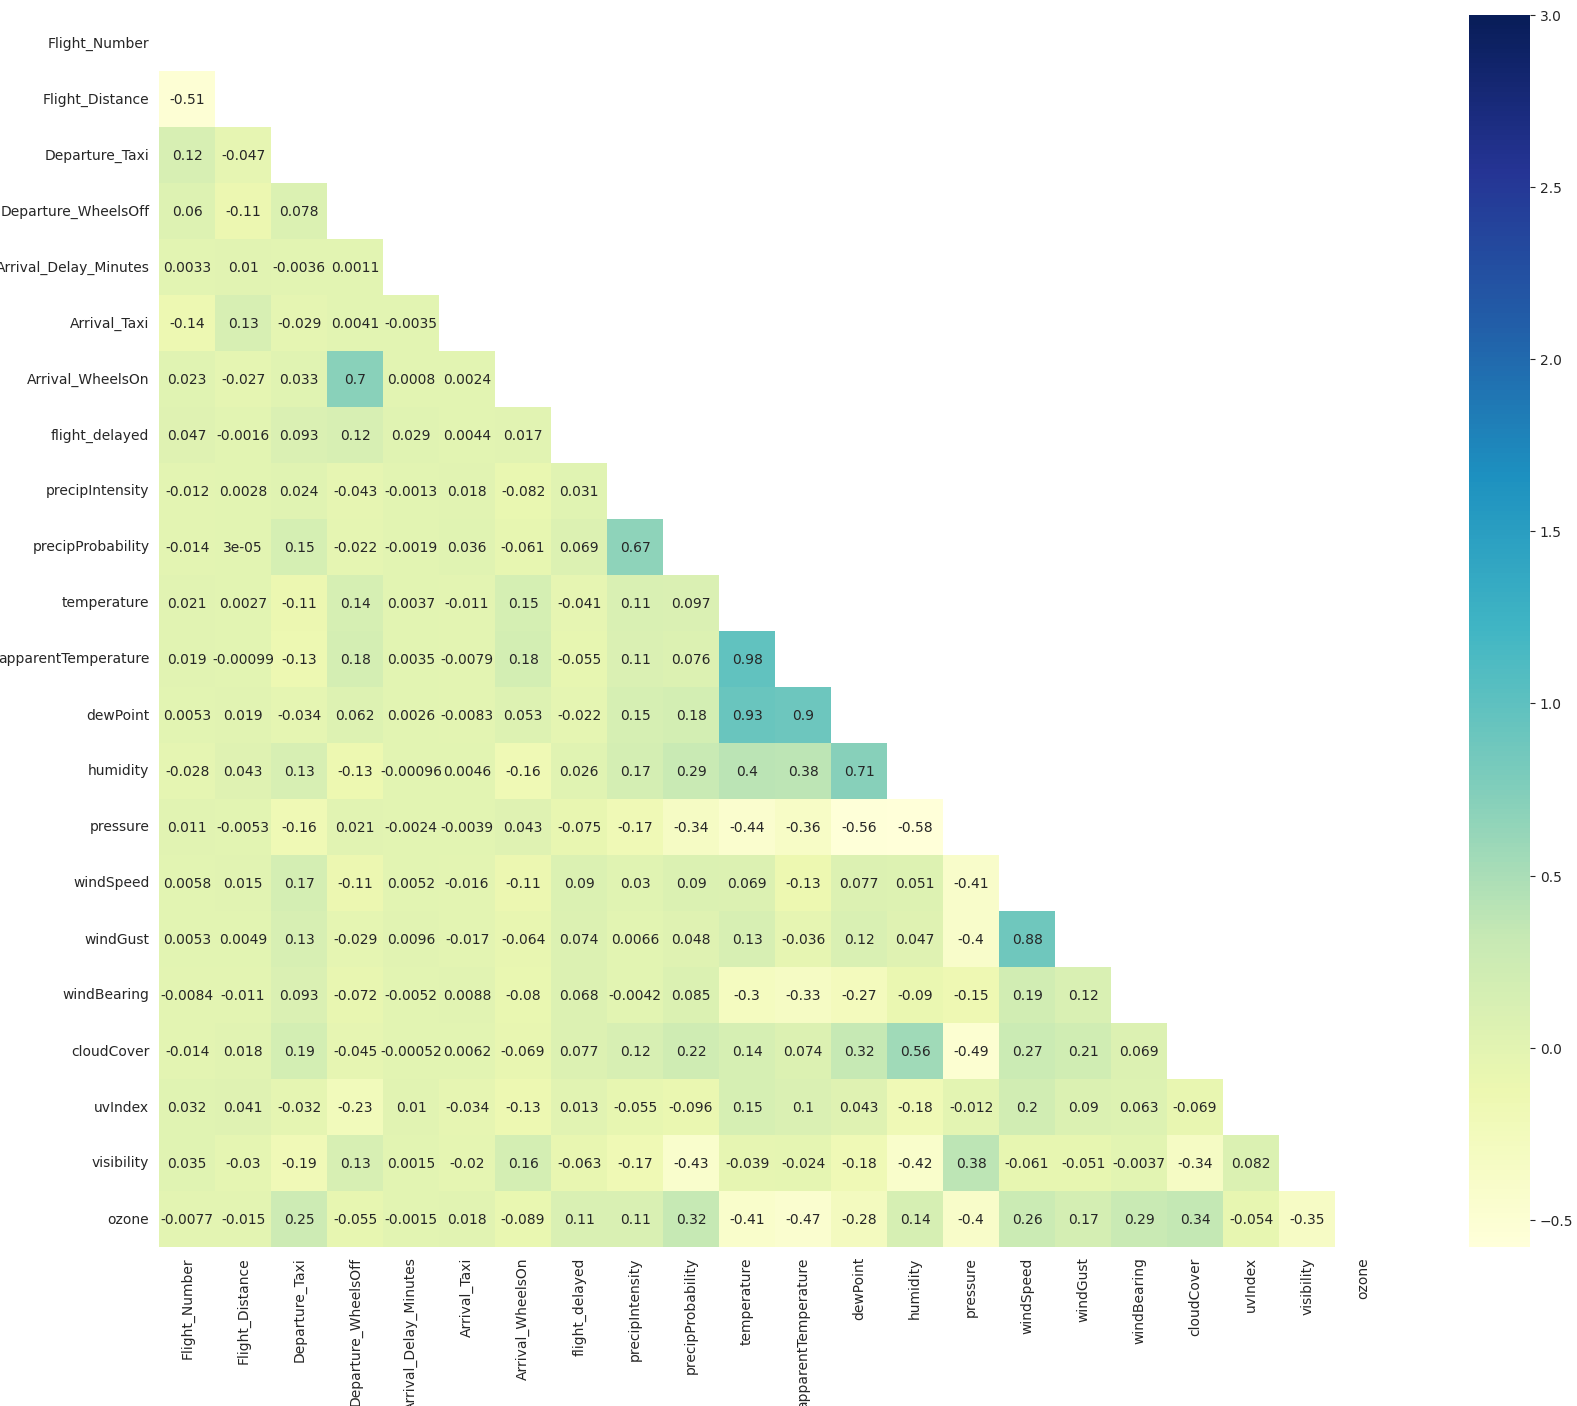

In [59]:
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20,16))
    ax = sns.heatmap(corrmat, mask=mask, vmax=3, square=True, annot=True, cmap="YlGnBu")

* No single factor seems to have a high correlation wtih flight_delayed
* Multicollinearity may exist due to features such as `apparentTemperature`,`dewpoint` and `temperature` having high collinearity with each other

# Don't notice high multicollinearity between variables here.
vif_cal(input_data=hix_merged_dep_wthr_df2, dependent_col="flight_delayed")

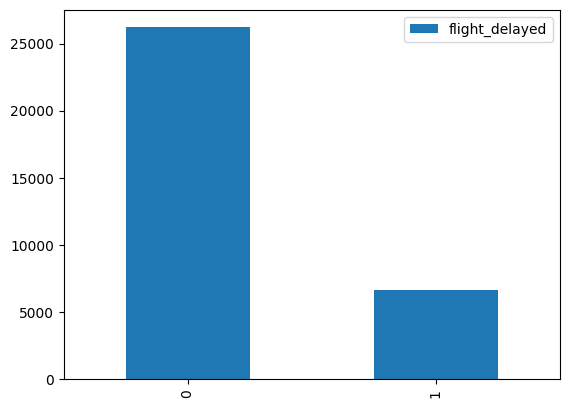

In [60]:
# Note we have an imbalanced class problem when looking at our delays
pd.DataFrame(hix_merged_dep_wthr_df2.flight_delayed.value_counts()).plot(kind='bar')
plt.show()

In [61]:
hix_merged_dep_wthr_df2.flight_delayed.value_counts()

0    26201
1     6662
Name: flight_delayed, dtype: int64

In [62]:
# Ratio of oversampled vs undersampled classes
round(len(hix_merged_dep_wthr_df2[hix_merged_dep_wthr_df2.flight_delayed == 0]) / len(hix_merged_dep_wthr_df2[hix_merged_dep_wthr_df2.flight_delayed == 1]))

4

We can handle the imbalanced data in one of three ways:

1. Use algorithms such as XG Boost which handle imbalanced classes
1. Use synthtetic minority over/under sampling 
1. Use ROC-AUC, Recall and Precision

## Feature Engineering
---

In [63]:
X = hix_merged_dep_wthr_df2.drop(['flight_delayed'], axis=1)
y = hix_merged_dep_wthr_df2.flight_delayed

In [64]:
X.head()

,Airline,Flight_Number,Plane_ID,FlightDate,Origin_Airport,Destination_Airport,Flight_Distance,Scheduled_Departure_Time,Actual_Departure_Time,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Scheduled_Arrival_Time,Actual_Arrival_Time,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,FlightSchedDepDateTime,FlightActualDepDateTime,FlightSchedArrDateTime,FlightActualArrDateTime,Sched_Departure_Hour,Actual_Departure_Hour,Sched_Arrival_Hour,Actual_Arrival_Hour,airport,time,summary,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone
0,RO,4754,GHHWLL,2019-12-01,HIX,IZN,413.0,0010,0010,0.0,15.0,25.0,0242,0227,0.0,5.0,222.0,2019-12-01 00:10:00,2019-12-01 00:10:00,2019-12-01 02:42:00,2019-12-01 02:27:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
1,XM,5604,GBGWFC,2019-12-01,HIX,IZU,130.0,0010,0044,34.0,34.0,118.0,0111,0155,44.0,4.0,151.0,2019-12-01 00:10:00,2019-12-01 00:44:00,2019-12-01 01:11:00,2019-12-01 01:55:00,2019-12-01,2019-12-01,2019-12-01 01:00:00,2019-12-01 01:00:00,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
2,XM,5661,GBESAF,2019-12-01,HIX,EZN,552.0,0010,0014,4.0,24.0,38.0,0206,0219,13.0,11.0,208.0,2019-12-01 00:10:00,2019-12-01 00:14:00,2019-12-01 02:06:00,2019-12-01 02:19:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
3,NR,3741,GDJRDD,2019-12-01,HIX,FJS,836.0,0010,0003,0.0,14.0,17.0,0234,0226,0.0,3.0,223.0,2019-12-01 00:10:00,2019-12-01 00:03:00,2019-12-01 02:34:00,2019-12-01 02:26:00,2019-12-01,2019-12-01,2019-12-01 02:00:00,2019-12-01 02:00:00,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28
4,NR,3535,GEKWHO,2019-12-01,HIX,LRN,1041.0,0010,0055,45.0,11.0,106.0,0310,0334,24.0,4.0,330.0,2019-12-01 00:10:00,2019-12-01 00:55:00,2019-12-01 03:10:00,2019-12-01 03:34:00,2019-12-01,2019-12-01,2019-12-01 03:00:00,2019-12-01 03:00:00,Highland,2019-12-01,Possible Drizzle,0.0089,0.49,39.9,35.34,37.27,0.91,996.13,6.2,7.78,128.083784,1.0,0,6.396,368.28


In [65]:
y.head()

0    0
1    1
2    0
3    0
4    1
Name: flight_delayed, dtype: int64

##### Convert categorical variables into numeric values

In [69]:
X.describe()

,Flight_Number,Flight_Distance,Departure_Delay_Minutes,Departure_Taxi,Departure_WheelsOff,Arrival_Delay_Minutes,Arrival_Taxi,Arrival_WheelsOn,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone
count,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,3.286300e+04,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000,32863.000000
mean,4282.909899,692.771902,15.907982,23.246174,1425.169522,3.425158e+02,6.822627,1552.112132,0.000598,0.024651,35.063654,29.178622,25.674000,0.697142,1016.711052,8.276961,10.774153,225.614167,0.575187,0.332410,9.642702,334.942631
std,1584.647974,502.315076,53.117533,12.092565,477.320688,2.215887e+04,5.458769,514.818739,0.005419,0.122115,10.073344,12.561648,12.695179,0.134505,9.646524,3.551854,6.243013,67.387182,0.354827,0.503374,1.050224,29.937426
min,1322.000000,67.000000,0.000000,4.000000,1.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,11.530000,-1.590000,-13.040000,0.230000,993.040000,0.510000,0.750000,0.008510,0.000000,0.000000,1.193000,270.130000
25%,2801.500000,299.000000,0.000000,16.000000,1025.000000,0.000000e+00,4.000000,1202.000000,0.000000,0.000000,28.760000,20.590000,20.850000,0.630000,1010.290000,5.730000,6.450000,193.049447,0.240000,0.000000,10.000000,316.920000
50%,4623.000000,599.000000,0.000000,20.000000,1423.000000,0.000000e+00,5.000000,1547.000000,0.000000,0.000000,34.620000,28.800000,26.490000,0.710000,1018.390000,8.110000,9.650000,221.064789,0.620000,0.000000,10.000000,336.250000
75%,5428.000000,888.000000,8.000000,27.000000,1843.000000,1.100000e+01,8.000000,2015.000000,0.000000,0.000000,42.060000,36.820000,31.760000,0.780000,1024.650000,10.410000,13.170000,269.060469,0.940000,1.000000,10.000000,353.050000
max,7613.000000,4243.000000,1223.000000,156.000000,2359.000000,2.510000e+06,160.000000,2400.000000,0.118500,1.000000,61.750000,61.590000,55.150000,0.990000,1034.260000,20.300000,34.300000,357.019950,1.000000,2.000000,10.000000,423.560000


In [67]:
categorical_profiling(X)

,column,values,unique,modal_value,values_count_incna,values_count_nona,num_miss,pct_miss,values_count_exclna
0,Airline,"[RO, XM, NR, SN, CA, ZH, TR, TO, FH, WC, LV, UG, GB, TJ, YJ, VF]",16,NR,16,NaN,0,0.0,16.0
0,Plane_ID,"[GHHWLL, GBGWFC, GBESAF, GDJRDD, GEKWHO, GGFVEG, GEJNNK, GEETNK, GEJRNK, GBDSDC, GBJSBG, GGDWHL, GBHWFM, GJGUFK, GHMUFY, GIHNHO, GDLRBB, GFHQTX, GEFRNK, GEKOMK, GEJNHO, GIHOHO, GDLRBY, GHJPCG, GHK...",2681,GFHSTX,2681,NaN,0,0.0,2681.0
0,FlightDate,"[2019-12-01, 12/01/2019, 2019-12-02, 12/02/2019, 2019-12-03, 12/03/2019, 2019-12-04, 12/04/2019, 2019-12-05, 12/05/2019, 2019-12-06, 12/06/2019, 2019-12-07, 12/07/2019, 2019-12-08, 12/08/2019, 201...",62,2019-12-01,62,NaN,0,0.0,62.0
0,Origin_Airport,[HIX],1,HIX,1,NaN,0,0.0,1.0
0,Destination_Airport,"[IZN, IZU, EZN, FJS, LRN, UFM, VNU, TQI, KJN, LRP, VCY, ZJJ, VYM, TMJ, FTC, LPL, ULZ, TSY, VYI, KFW, FJJ, WJG, FTI, KUO, UUF, LWI, IYF, MPM, VDB, WRS, VRY, LUZ, BRX, LKF, VFO, VZX, XMP, FJH, KZW, ...",168,EXU,168,NaN,0,0.0,168.0
0,Scheduled_Departure_Time,"[0010, 0015, 0020, 0022, 0030, 2015, 2035, 2110, 2145, 2200, 2220, 2230, 2240, 2300, 2305, 2320, 0025, 1935, 2205, 1000, 1005, 1125, 1140, 1153, 1155, 1200, 1201, 1205, 1206, 1208, 1209, 1210, 121...",770,1000,770,NaN,0,0.0,770.0
0,Actual_Departure_Time,"[0010, 0044, 0014, 0003, 0055, 0029, 0009, 0023, 0006, 0013, 0011, 0017, 0030, 0022, 0016, 0032, 0059, 0001, 0002, 0036, 0025, 0024, 0045, 0019, 0020, 0234, 0236, 0227, 0206, 0144, 0121, 0139, 010...",1203,0958,1203,NaN,0,0.0,1203.0
0,Scheduled_Arrival_Time,"[0242, 0111, 0206, 0234, 0310, 0325, 0121, 0132, 0328, 0233, 0307, 0333, 0149, 0309, 0255, 0308, 0306, 0147, 0139, 0401, 0324, 0329, 2306, 2329, 2349, 2312, 0021, 0030, 0133, 0103, 0142, 0146, 014...",1030,2158,1030,NaN,0,0.0,1030.0
0,Actual_Arrival_Time,"[0227, 0155, 0219, 0226, 0334, 0336, 0119, 0211, 0108, 0341, 0228, 0309, 0335, 0259, 0147, 0301, 0246, 0253, 0322, 0235, 0130, 0131, 0410, 0327, 0349, 0316, 0222, 0151, 0240, 0323, 0304, 0256, 025...",1221,2153,1221,NaN,0,0.0,1221.0
0,airport,[Highland],1,Highland,1,NaN,0,0.0,1.0


In [66]:
X_train, y_train, X_test, y_test = shuffle_split_data(X,y)

23004 23004 9859 9859
